Face-tracing algorithm
=========================

Problem: given a set of lines, identify all closed regions (subshapes).

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import hestus
from importlib import reload

In [8]:
reload(hestus)

<module 'hestus' from '/Users/nemmen/Library/CloudStorage/Dropbox/codes/jupyter/projects/hestus-problem/hestus.py'>

## Shapes

In [4]:
square = (
    ((1, 1), (1, 2)),
    ((1, 2), (2, 2)),
    ((2, 2), (2, 1)),
    ((2, 1), (1, 1)),
)

In [3]:
hourglass=( ((1, 1), (1, 2)),
((1, 2), (2, 1)),
((2, 1), (2, 2)),
((2, 2), (1, 1)), )

In [5]:
window= ( ((1, 1), (1, 2)),
((1, 2), (2, 2)),
((2, 2), (2, 1)),
((2, 1), (1, 1)),
((1.5, 1), (1.5, 2)),
((1, 1.5), (2, 1.5)), )

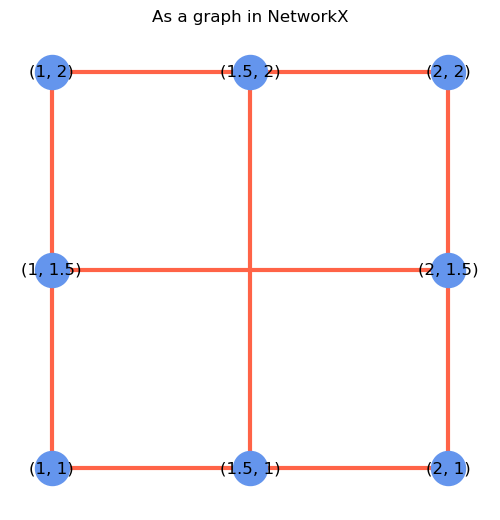

In [9]:
hestus.plot_graph(window)